In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [378]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl
from copy import deepcopy, copy
import time


In [4]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *
from src.util import *

In [5]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


/rds/user/njr61/hpc-work/anaconda3/envs/gnn/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [7]:
epochs = 3000
dim = 20

## Model Setup

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = NetSmall(num_features=num_features, dim=dim, num_classes=num_classes).to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [11]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:1.326829 Train_acc: 0.2679, Test_acc: 0.0714]: 100%|█| 3000/300


In [12]:
model.eval()

NetSmall(
  (conv1): GCNConv(1, 20)
  (conv2): GCNConv(20, 20)
  (linear): Linear(in_features=20, out_features=4, bias=False)
)

In [13]:
gce_explainer = GCExplainer(layer_name="conv2")

In [14]:
gce_explainer.learn_prototypes(model,ba_dataset)

/rds/user/njr61/hpc-work/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
gce_explainer.get_prediction(model,ba_dataset)

array([2, 3, 3, 0, 3, 3, 0, 2, 3, 3, 0, 3, 0, 3, 3, 0, 3, 2, 0, 1, 3, 3,
       0, 3, 3, 1, 1, 3, 2, 0, 0, 0, 3, 1, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3,
       1, 3, 3, 0, 0, 2, 1, 1, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 3, 3, 0, 0,
       0, 2, 2, 3, 0, 1, 2, 2, 2, 2, 0, 0, 0, 3, 3, 0, 2, 3, 3, 1, 0, 0,
       0, 0, 3, 1, 0, 2, 0, 0, 1, 2, 2, 0, 3, 1, 0, 3, 3, 0, 1, 1, 3, 1,
       0, 2, 2, 3, 3, 2, 3, 0, 2, 3, 0, 3, 2, 3, 0, 3, 3, 1, 1, 0, 3, 3,
       1, 3, 0, 1, 1, 2, 2, 1])

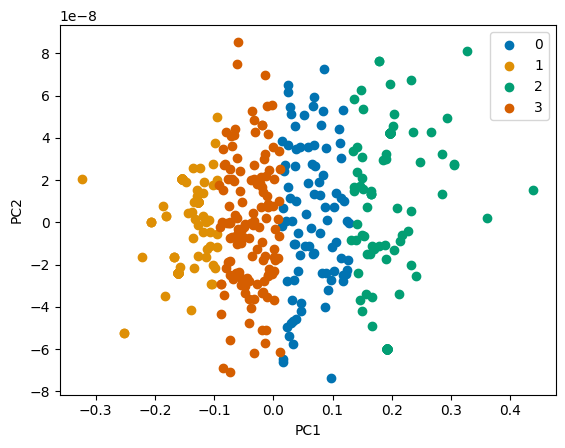

In [16]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

## Low-Level Matrices

In [17]:
num_nodes = ba_dataset.num_nodes
num_features = ba_dataset.num_features
edge_index = ba_dataset.edge_index
targeted_node = 5
num_gcn_layers = sum(1 for module in model.modules() if isinstance(module, GCNConv))

In [18]:
all_activations, points_by_cluster = gce_explainer.get_prediction(model,ba_dataset,test=False, get_activations=True)
centers = gce_explainer.kmeans.cluster_centers_
current_vector = all_activations[targeted_node]

In [19]:
A = np.zeros((num_nodes,num_nodes))
for a,b in ba_dataset.edge_index.T:
    A[a,b] = A[b,a] = 1
A_identity = np.eye(num_nodes)
A_squiggle = A + A_identity
X = ba_dataset.x.detach().numpy()
W = compute_W(model)

In [20]:
A_hat = compute_A_hat(A_squiggle)
AXW = compute_AXW(A_hat,X,W,num_gcn_layers)

## Run the Targeted Attack on Simplified AXW

In [206]:
def new_score_function(current_location,centers,current_prediction):
    distances = get_kmeans_distances(centers,current_location)
    return -np.min(np.delete(distances,current_prediction))

In [379]:
def new_score_function_2(current_location,centers,current_prediction):
    distances = get_kmeans_distances(centers,current_location)
    return distances[current_prediction]/np.min(np.delete(distances,current_prediction))

In [207]:
def changes_work(centers,A_squiggle,X,W,num_gcn_layers,targeted_node,changes):
    A_hat = compute_A_hat(A_squiggle)
    AXW = compute_AXW(A_hat,X,W,num_gcn_layers)
        
    old_prediction = np.argmin(get_kmeans_distances(centers,AXW[targeted_node]))
    
    A_squiggle_new, X_new = modify_A_X(changes_minmax,A_squiggle,X)
        
    A_hat_new = compute_A_hat(A_squiggle_new)
        
    AXW_new = compute_AXW(A_hat_new,X_new,W,num_gcn_layers)
    
    new_prediction = np.argmin(get_kmeans_distances(centers,AXW_new[targeted_node]))
    return new_prediction != old_prediction

In [380]:
allowable_nodes = np.where(ba_dataset.test_mask.detach().numpy())[0]
allowable_nodes = np.random.choice(allowable_nodes, size=int(0.1*len(allowable_nodes)), replace=False)

In [381]:
success = []
num_changes = [] 
time_needed = []

In [382]:
for i in range(3):
    temp_success = []
    temp_changes = []
    temp_time = []
    
    random_test_indices = np.where(ba_dataset.test_mask.detach().numpy())[0]
    random_test_indices = np.random.choice(random_test_indices, size=int(0.1*len(random_test_indices)), replace=False)
    for targeted_node in random_test_indices:
        start = time.time()
        targeted_node = int(targeted_node)
        changes_minmax = targeted_attack(ba_dataset,gce_explainer,model,targeted_node,10,
                           new_score_function,allowable_nodes)
        end = time.time()
        temp_changes.append(len(changes_minmax))
        temp_success.append(changes_work(centers,A_squiggle,X,W,num_gcn_layers,targeted_node,changes_minmax))
        temp_time.append(end-start)
    
    success.append(temp_success)
    num_changes.append(temp_changes)
    time_needed.append(temp_time)

In [383]:
allowable_nodes = np.where(ba_dataset.test_mask.detach().numpy())[0]
allowable_nodes = np.random.choice(allowable_nodes, size=int(0.2*len(allowable_nodes)), replace=False)

In [384]:
success_2 = []
num_changes_2 = [] 
time_needed_2 = []

In [385]:
for i in range(3):
    temp_success = []
    temp_changes = []
    temp_time = []
    
    random_test_indices = np.where(ba_dataset.test_mask.detach().numpy())[0]
    random_test_indices = np.random.choice(random_test_indices, size=int(0.1*len(random_test_indices)), replace=False)
    for targeted_node in random_test_indices:
        start = time.time()
        targeted_node = int(targeted_node)
        changes_minmax = targeted_attack(ba_dataset,gce_explainer,model,targeted_node,10,
                           new_score_function,allowable_nodes)
        end = time.time()
        temp_changes.append(len(changes_minmax))
        temp_success.append(changes_work(centers,A_squiggle,X,W,num_gcn_layers,targeted_node,changes_minmax))
        temp_time.append(end-start)
    
    success_2.append(temp_success)
    num_changes_2.append(temp_changes)
    time_needed_2.append(temp_time)

In [386]:
success_diff_score = []
num_changes_diff_score = [] 
time_needed_diff_score = []

In [387]:
for i in range(3):
    temp_success = []
    temp_changes = []
    temp_time = []
    
    random_test_indices = np.where(ba_dataset.test_mask.detach().numpy())[0]
    random_test_indices = np.random.choice(random_test_indices, size=int(0.1*len(random_test_indices)), replace=False)
    for targeted_node in random_test_indices:
        start = time.time()
        targeted_node = int(targeted_node)
        changes_minmax = targeted_attack(ba_dataset,gce_explainer,model,targeted_node,10,
                           new_score_function,allowable_nodes)
        end = time.time()
        temp_changes.append(len(changes_minmax))
        temp_success.append(changes_work(centers,A_squiggle,X,W,num_gcn_layers,targeted_node,changes_minmax))
        temp_time.append(end-start)
    
    success_diff_score.append(temp_success)
    num_changes_diff_score.append(temp_changes)
    time_needed_diff_score.append(temp_time)

KeyboardInterrupt: 

In [392]:
time_needed_diff_score[0]

[0.3448479175567627,
 1.2426960468292236,
 1.6866166591644287,
 3.2005038261413574,
 0.9281718730926514,
 3.8996355533599854,
 66.92805695533752,
 1.2964601516723633,
 11.764107704162598,
 38.16520595550537,
 5.057437419891357,
 0.8447177410125732,
 6.124061584472656,
 0.3247978687286377]

## Run the Targeted Attack on the Real Dataset

In [393]:
def modify_dataset(changes,dataset):
    new_dataset = deepcopy(dataset)
    for change in changes:
        if change[0] == "A":
            edge_num = [change[1],change[2]]
            if change[-1] == 0:
                indices = (new_dataset.edge_index[0] == change[1]) & (new_dataset.edge_index[1] == change[2])
                indices |= (new_dataset.edge_index[0] == change[2]) & (new_dataset.edge_index[1] == change[1])
                new_dataset.edge_index = new_dataset.edge_index[:, ~indices]
            else:
                new_dataset.edge_index = torch.cat((new_dataset.edge_index, 
                                                    torch.tensor([[change[1]], [change[2]]])), dim=1)
        else:
            new_dataset.X[change[1],change[2]] = change[3]

    return new_dataset

In [394]:
targeted_node = 561
changes_minmax = targeted_attack(ba_dataset,gce_explainer,model,targeted_node,10,
                   new_score_function,allowable_nodes)
new_dataset = modify_dataset(changes_minmax,ba_dataset)

In [401]:
all_activations, points_by_cluster = gce_explainer.get_prediction(model,ba_dataset,test=False, get_activations=True)

In [402]:
new_activations, points_by_cluster = gce_explainer.get_prediction(model,new_dataset,test=False, get_activations=True)

In [405]:
new_dataset.edge_index, ba_dataset.edge_index

(tensor([[ 38,  43,  54,  ..., 638, 665, 631],
         [  0,   1,   2,  ..., 593, 652, 581]]),
 tensor([[ 38,  43,  54,  ..., 695, 697, 699],
         [  0,   1,   2,  ..., 697, 698, 698]]))

## Debugging

In [318]:
a = set()
a.add(5)
a.union(set([6]))
a

{5}

In [296]:
A_squiggle,i,j= changes_minmax

In [297]:
A_squiggle_new = copy(A_squiggle)
A_squiggle_new[i,j] = 1-A_squiggle[i,j]

In [321]:
new_D_half = compute_D_half(A_squiggle_new)
predicted_A_hat = new_D_half.dot(A_squiggle_new).dot(new_D_half)
visitable_nodes = get_n_hop(A_squiggle_new,561,num_gcn_layers)

In [332]:
np.linalg.norm(A_squiggle_new)

64.98461356351979

In [335]:
sum(visitable_nodes)

124122

In [327]:
predicted_A_hat_pow = get_adjacency_power(A_squiggle_new,new_D_half,num_gcn_layers,561,visitable_nodes)

three hop [186, 187, 188, 192, 221, 269, 295, 296, 309, 329, 330, 331, 332, 333, 337, 343, 344, 350, 352, 362, 365, 367, 372, 373, 374, 375, 376, 377, 378, 379, 384, 386, 389, 394, 401, 402, 403, 404, 410, 411, 418, 420, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 437, 438, 441, 442, 444, 445, 446, 448, 449, 450, 452, 453, 454, 456, 457, 458, 460, 461, 463, 464, 466, 468, 469, 473, 474, 476, 477, 478, 479, 480, 481, 482, 484, 485, 487, 488, 489, 491, 494, 496, 497, 498, 500, 502, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 533, 535, 536, 537, 538, 539, 540, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 576, 577, 578, 579, 580, 581, 582, 584, 587, 588, 589, 590, 591, 593, 594, 597, 598, 600, 602, 605, 606, 607, 608, 613, 614, 615, 616, 620, 621, 622, 624, 625, 626, 628,

In [328]:
real_A_hat = compute_A_hat(A_squiggle_new)
real_A_hat_pow = np.linalg.matrix_power(real_A_hat,num_gcn_layers)

In [358]:
len(np.where(np.linalg.matrix_power(A_hat,num_gcn_layers)[561])[0])

237

In [329]:
predicted_A_hat_pow[330],real_A_hat_pow[561][330]

(0.017407765595569783, 0.017407765595569783)

In [355]:
len(get_n_hop(A_squiggle,561,num_gcn_layers))

237

In [313]:
np.where(predicted_A_hat[330])[0]

array([185, 330, 332, 560])